1. Explain the overall purpose of the package.
2. Explain the use of the “Simple random data” and “Permutations” functions.
3. Explain the use and purpose of at least five “Distributions” functions.
4. Explain the use of seeds in generating pseudorandom numbers.

# The numpy.random Package

## Introduction 
### True random number generation

True random number generation is not a simple matter. It is difficult to find phenomena that are unpredictable to the extent that they can provide a long-lasting stream of data from which truly random numbers can be derived. Many applications require cryptographically secure random number generation and there is much research into sources of entropy as diverse as spontaneous chaotic oscillations in semiconductor superlattices [11], atmospheric noise [12], and synthesised DNA strands composed of random nucleotides [13] for the purposes of random number generation. Computer programmes are by nature deterministic making it difficult to generate truly unpredictable random numbers without some external source of entropy [R]. 

Where phenomena are identified which can provide streams of random data, such as for instance the electromagnetic noise arising from current flow across a transistor, the signal from which the data is generated must be processed to remove bias and make uniform to counteract effects such as temperature and voltage fluctuations. Failure to do so could introduce inadvertent predictability or provide a route for bad actors to influence the random bit stream [14].

### Pseudorandom number generation and Seeding
The vast majority of applications for which random numbers are generated consume data generated by a pseudorandom number generator (PRNG). A PRNG, also known as a *deterministic* random *bit generator* [15], is an algorithm that, given some initial value, known as a seed, manipulates that seed in some way, then iteratively manipulates the result of that manipulation, and so on, to produce a stream of random bits from which samples can be drawn. Melissa O' Neill, creator of the PCG family of PRNG algorithms, one of which, PCG64, is the default `numpy.random` PRNG, uses the analogy of an enormous book filled with numbers from which the random sequences are drawn [R]. While all of the numbers in this book are accessible to anyone who cares to look, the chances of finding the particular page on which a particular sequence of numbers commences are infinitesimal.


However, if the page, line, and character number at which to begin was provided, reproducing a sequence of numbers would be easy. Pseudorandom number generators are akin to this book in the sense that they are deterministically produced using a single value as a starting point. The PRNG analogue to the location of the beginning of the random number sequence in the book of numbers is the seed.

## Overview
The `numpy.random` package is the part of numpy that deals with the generation of random data. The package provides an interface to a number of PRNG algorithms. Methods are provided to generate simple random data, or data sampled from a number of statistical distributions, as well as for shuffling the contents of existing array-like structures.

The available PRNG algorithms, or *bit generators*, are extended from the abstract `numpy.random.BitGenerator` class, which provides a constructor that accepts a seed parameter for the PRNG seed. 
Two classes `numpy.random.BitGenerator` and `numpy.random.Generator` are used together to generate pseudo random numbers. `Generator` can be instantiated in two ways;

1. by calling the constructor with the name of the desired BitGenerator algorithm, or;
1. by calling `numpy.random.default_rng()`, a convenience function which will return a `Generator` object instantiated with the default `BitGenerator`, currently PCG64 [1]  

The second method is the one recommended by the numpy documentation [1].

`numpy.random.BitGenerator` is the base class for all of the bit generators provided by the numpy package. It is an abstract class and so cannot be instantiated. Several BitGenerators are provided by numpy. Of particular interest are `PCG64`, the default `numpy.random` BitGenerator, and `MT19937`, also known as the *Mersenne Twister*[1], the Python language's standard BitGenerator[1]. The `BitGenerator` base class provides the attribute `seed` which is used to initialise whichever BitGenerator is instantiated so that the sequence of numbers it produces are deterministic and therefore reproduceable[8]. If no seed is passed one is generated from system entropy[9]. Whether a seed is passed or not, the `numpy.random.SeedSequence` class is used to generate the `BitGenerator`'s initial state [9].

In [1]:
# Imports
import numpy as np
# Used to initialise current default BitGenerator
from numpy.random import default_rng
# Used to initialise any available BitGenerator
from numpy.random import Generator
# Two of numpy's BitGenerators
from numpy.random import PCG64, MT19937
# For plotting distributions, etc
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
from tabulate import tabulate
from faker import Faker
# math.comb calculates n choose N
from math import comb

In [2]:
# Set global plot style
plt.style.use('seaborn')

The recommended method for intialising a random number generator is with the `numpy.random.default_rng()` function [1]. This returns a `Generator` object. The `Generator`'s bit generator can be accessed via its `bit_generator` attribute. It can be seen here that calling `default_rng` has returned a `Generator` intitialised with the `PCG64` bit generator.

In [3]:
# Initialise Generator with default 
# BitGenerator (PCG64) with seed 0
rng = default_rng(99)
print(f"Type returned by default_rng():\t\t{type(rng)}")
print(f"BitGenerator returned by default_rng():\t{type(rng.bit_generator)}")

Type returned by default_rng():		<class 'numpy.random._generator.Generator'>
BitGenerator returned by default_rng():	<class 'numpy.random._pcg64.PCG64'>


The bit generator's state can be inspected with it's `state` attribute. The long numerical value keyed by 'state' is dependent on where in its deterministic raw pseudo-random number production journey it is. This number changes every time the bit generator is asked to produce a number. The value keyed by 'inc' encodes the generator's seed and only changes when the seed is changed.

It is not usually necessary to directly access the bit generator or its state but it does have one potentially very useful application in that the state can be saved and reloaded to a generator, as is demonstrated below.

In [4]:
print("State of BitGenerator returned by default_rng(99):")
display(rng.bit_generator.state)
# save current state
rng_state = rng.bit_generator.state

State of BitGenerator returned by default_rng(99):


{'bit_generator': 'PCG64',
 'state': {'state': 323145379500794079207071596454411015148,
  'inc': 324459057272246375853630270025492255805},
 'has_uint32': 0,
 'uinteger': 0}

In [5]:
# Instantiate a new rng
new_rng = np.random.default_rng()
# View the state
display(new_rng.bit_generator.state)

{'bit_generator': 'PCG64',
 'state': {'state': 76835729872197754314627654959181360309,
  'inc': 67270099338097139241814005512323573601},
 'has_uint32': 0,
 'uinteger': 0}

In [6]:
# Apply the saved rng state to the new rng
new_rng.bit_generator.state = rng_state
# The new rng state is now the same as the original
display(new_rng.bit_generator.state)

{'bit_generator': 'PCG64',
 'state': {'state': 323145379500794079207071596454411015148,
  'inc': 324459057272246375853630270025492255805},
 'has_uint32': 0,
 'uinteger': 0}

The `Generator` will usually be instantiated with a seed argument in order to produce reproducible random numbers. Naturally, different `BitGenerators` will produce different sequences of numbers despite having the same seed.

In [7]:
rng_pcg64_1 = Generator(PCG64(0))
rng_pcg64_2 = Generator(PCG64(0))
rng_mt19937_1 = Generator(MT19937(0))
rng_mt19937_2 = Generator(MT19937(0))
print(f"10 random integers from first pcg64 generator:    {rng_pcg64_1.integers(0,10, 10)}")
print(f"10 random integers from second pcg64 generator:   {rng_pcg64_2.integers(0,10, 10)}")
print(f"10 random integers from first mt19937 generator:  {rng_mt19937_1.integers(0,10, 10)}")
print(f"10 random integers from second mt19937 generator: {rng_mt19937_2.integers(0,10, 10)}")

10 random integers from first pcg64 generator:    [8 6 5 2 3 0 0 0 1 8]
10 random integers from second pcg64 generator:   [8 6 5 2 3 0 0 0 1 8]
10 random integers from first mt19937 generator:  [4 6 2 4 0 3 5 8 0 3]
10 random integers from second mt19937 generator: [4 6 2 4 0 3 5 8 0 3]


It is possible to take peek at the raw stream of numbers from which the higher level methods draw their samples.

In [8]:
pcg64 = PCG64(0)
print(pcg64.random_raw(10))

[11749869230777074271  4976686463289251617   755828109848996024
   304881062738325533 15002187965291974971 16837368535893154894
 11190454901533422207 13456836363123071557 10028111089635196863
 17249041691996241901]


Finally, as mentioned previously, where a seed is not supplied `numpy.random.SeedSequence` is used to generate a random seed using system entropy such as the precise core temperature. We can view the number generated 

In [9]:
seed_seq = np.random.SeedSequence()
print(seed_seq.entropy)

21034775946485524720006765679552584666


## Creating simple random data with `numpy.random`
The `Generator` class provides four methods for generating collections of random numbers when the probability distributions of those numbers is not important: `integers()`, which generates integers, `random()`, which generates floats,`choice()` which returns random selections from a passed list, and `bytes()`, which generates a string of random bytes.

### `numpy.random.Generator.integers()`
Signature : `integers(low, high=None, size=None, dtype=np.int64, endpoint=False)`

This method generates random integers in the interval $[low, high)$. It will return a single integer if called with one or two arguments. If called with one numeric argument, $a$ it will return an integer in the interval $[0, a)$, or, if the boolean argument `endpoint` is `True`, $[0, a]$. If called with two numeric arguments, $a, b$, the integer returned will be in the interval $[a, b)$; or $[a, b]$ if `endpoint=True`.

The method will return an array of random integers in the requested interval if given an argument for the `size` parameter. A single value will be interpreted as a length for a *1-d* array. A tuple will be interpreted as dimension sizes for an *n-d* array. Finally, an array-like data structure can be passed as the low or high range arguments in which case each member of the array will be interpreted as the low or high value for that element of an array of random integers.

The integers returned by this method follow a discrete uniform distribution, meaning that the number of possible values is countable and that each possible value is equally likely to occur.

Below, one million integers are generated in the interval $[1, 100]$ and are plotted in a histogram. The discrete uniform distribution is clear in the histogram.

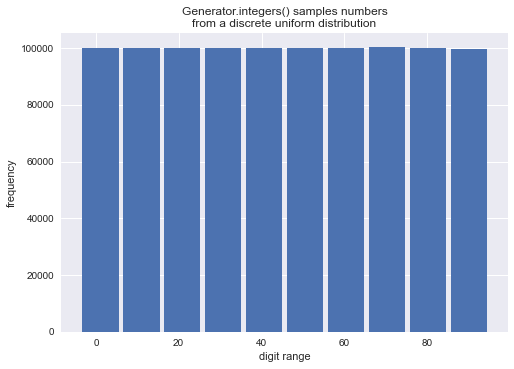

In [10]:
# Initialise random number generator with default bit generator (PCG64)
rng = default_rng(997878)
# Generate 1 million ints of simple random (discrete uniform) data 
ints = rng.integers(1, 100, 1000000, endpoint=True)
# plot number frequencies using matplotlib.pyplot.hist()
plt.hist(ints, bins=10, align="left", rwidth=0.9)

# Get current figure and Axes and set axis labels and plot title
ax = plt.gcf().gca()
ax.set_xlabel('digit range')
ax.set_ylabel('frequency')
plt.title("Generator.integers() samples numbers\nfrom a discrete uniform distribution")
plt.show()

Here, an array of integers is produced, each of which is limited to a different interval.

In [11]:
# Return an array containing 4 integers from 
# intervals [0,2), [0,4), [0,6), and [0,8) respectively 
rng.integers([2, 4, 6, 8])

array([0, 3, 0, 3])

*n-d* arrays can be generated by passing a tuple to size. Also lower and upper bounds can be specified for each position. Size can be inferred from the structure of the interval arguments.

In [12]:
# A 3x3 array of integers in [1, 100]
ints1 = rng.integers(1, 100, size=(3, 3), endpoint=True)

# A 3 element array with intervals [2, 5), [20, 50), and [200, 500)
ints2 = rng.integers([2, 20, 200], [5, 50, 500])

#  A 3x3 array with intervals:
#  [2, 300), [20, 300), [200, 300)
#  [2, 400), [20, 400), [200, 400)
#  [2, 500), [20, 500), [200, 500)
ints3 = rng.integers([2, 20, 200], [[300], [400], [500]])

print(f"5x5:\n{ints1}\n\n3 element:\n{ints2}\n\n3x3:\n{ints3}")

5x5:
[[29 84 18]
 [17 16 44]
 [37 54 50]]

3 element:
[  4  49 370]

3x3:
[[197 210 269]
 [ 50 246 230]
 [401 480 415]]


Simulating one million rolls of one and two fair dice using `Generator.integers()`. Note that a single dice produces a discrete uniform distribution and a 2 dice produce a discrete triangular distribution.

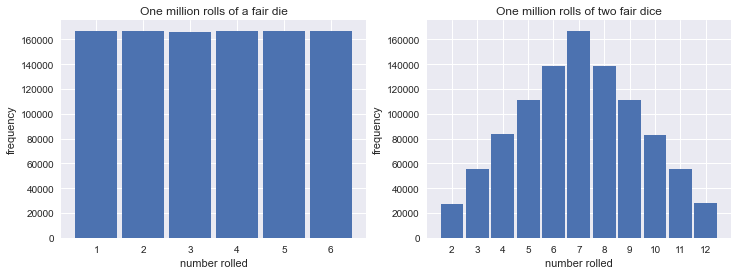

In [13]:
# Simulate 1 million die rolls
die_rolls = rng.integers(1, 6, size=1000000, endpoint=True)
# Simulating 1 million rolls of a pair of dice
two_die_rolls = rng.integers(1, 6, size=(1000000, 2), endpoint=True)

# Plot the distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.hist(die_rolls, bins=(range(1,8)), align="left", rwidth=0.9)
ax1.set_xlabel('number rolled')
ax1.set_ylabel('frequency')
ax1.set_title("One million rolls of a fair die")

ax2.hist(np.sum(two_die_rolls, axis=1), bins=(range(2, 14)), align="left", rwidth=0.9)
ax2.set_xlabel('number rolled')
ax2.set_ylabel('frequency')
ax2.set_xticks(range(2, 13))
ax2.set_title("One million rolls of two fair dice")
plt.show()

### `numpy.random.Generator.random()`
Signature: `random(size=None, dtype=np.float64, out=None)`

This method generates floats in the interval $[0.0, 1.0)$. With no arguments the method returns a single number. If an int is passed to the size parameter it is treated as the length of an array of floats, and if a tuple is passed each element is treated as the size of a dimension in an *n-d* array.

The random floats generated by this method are drawn from a continuous uniform distribution, meaning that the number of possible values is not countable but that each possible value is equally likely to occur. Collections of floats in intervals other than $[0.0, 1.0)$ may be generated by adding the lower interval limit the product of the interval length and the output of `random()`; for example an array of dimensions $(i\times j)$ containing random floats in the interval $[a,b)$ would be produced with `(b-a)(random((i,j))+a`.

***
A histogram of one million values generated by `Generator.random()`demonstrates the uniform distribution of those values.

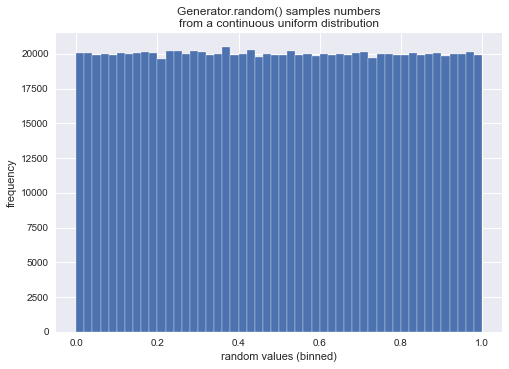

In [14]:
# Generate array of 1000000 random floats in [0.0, 1.0)
floats = rng.random(1000000)

#Plot a histogram with 50 bins
plt.hist(floats, bins=50, edgecolor='white')
# Get current figure and Axes and set axis labels and plot title
ax = plt.gcf().gca()
ax.set_xlabel('random values (binned)')
ax.set_ylabel('frequency')
plt.title("Generator.random() samples numbers\nfrom a continuous uniform distribution")
plt.show()

A $(3\times 3)$ array of floats in $[5,10)$ is produced by `(10-5)*Generator.random((3,3))+5`.

In [15]:
# Generate 3x3 array of floats in [5,10)
floats = (10-5)*rng.random((3,3))+5 
print(floats)

[[9.09311376 8.9235276  6.03026354]
 [8.25592295 8.78959722 5.50676069]
 [7.74609353 9.36405525 9.87746473]]


### `numpy.random.Generator.choice()`
Signature: `choice(a, size=None, replace=True, p=None, axis=0, shuffle=True)`

This method returns random samples from array-like collections. Passed an int it will behave like [`Generator.integers()`](numpy.random.Generator.integers()) and treat the argument as the upper limit of a half-open interval, with closed lower limit at 0, returning a random integer from that interval. 

The `size` parameter, along with the input *array-like*, $a$, controls the shape of the output array. Assuming $a$ is a *1-d* array, `size`=`None` returns a single value; `size`= an int, $n$, returns a *1-d* array of values of length $n$; and `size` = a tuple returns an *n-d* array, the length of which is the length of the tuple and the length of each dimension the corresponding value in the tuple. This works similarly where $a$ is *2-or-higher-d* array, except that each element returned is an array, taken from the axis of $a$ specified by the `axis` argument, rather than a single value.

Whether or not the sample is taken with replacement, that is whether a value can be selected more than once, can be specified with the `replace` parameter.

The random values are selected using a uniform distribution, with each value having an equal chance of being selected. However, an array-like collection of probabilities can be passed, one for each possible choice. Naturally, these probabilities must sum to 1.

***
Selecting from a *1-d* array, and using the `size` parameter to output an *n-d* array, read the `size` tuple from right to left to figure out what you'll get. Below, `size=(2, 3)` means *Randomly pick three digits from the input array and place them in an array, do that twice, and put both of the resulting arrays into an array*.

In [16]:
# Choose a single random integer from [0, 10)
one = rng.choice(10)
# Select 3 numbers twice from [0,10)
three_twice = rng.choice(10, size=(2, 3), axis=1)
print(f"Choose one number from [0, 10):\n {one}\n")
print(f"Choose three numbers twice from [0, 10):\n {three_twice}\n")
print(f"Shape of three, twice: {three_twice.shape}")

Choose one number from [0, 10):
 9

Choose three numbers twice from [0, 10):
 [[1 3 0]
 [1 3 1]]

Shape of three, twice: (2, 3)


When the input to `Generator.choice()` is an *n-d > 1* array, the values chosen are not individual values but arrays chosen from along whatever axis is specified by the `axis` parameter.

In [17]:
# A 4x4 array holding digits from 1-16
a = np.array(np.arange(1,17)).reshape(4,4)
# Choose two rows at random with replacement
two_rows = rng.choice(a, size=(2), axis=0)
# Choose two columns at random with replacement
two_cols = rng.choice(a, size=(2), axis=1)


print(f"Input array:\n {a}\n")
print(f"Choose two rows at random:\n {two_rows}", '\n')
print(f"Choose two columns at random:\n {two_cols}", '\n')

Input array:
 [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

Choose two rows at random:
 [[ 5  6  7  8]
 [13 14 15 16]] 

Choose two columns at random:
 [[ 1  4]
 [ 5  8]
 [ 9 12]
 [13 16]] 



When the input is an *n-d > 1* array, and the `size` is a tuple, the choice is a slice along the axis specified by `axis` which is repeated and assembled into an *n-d* array according to the values in the `size` tuple. Below, `size=(3, 2, 2)` (with `axis=0`) can be read as *Randomly choose two rows from the input array and place them in an array. Do that twice, and put the resulting two arrays into an array. Now do all of that twice more, for a total of three times, and put all of the resulting arrays into an array*. This is more succinctly expressed as *Choose two rows twice, three times*.

In [18]:
# Select one row, three times, and do that twice
two_rows_twice_three_times = rng.choice(a, size=(3, 2, 2), axis=0)

print(two_rows_twice_three_times, '\n')
print(two_rows_twice_three_times.shape)

[[[[ 5  6  7  8]
   [13 14 15 16]]

  [[ 1  2  3  4]
   [ 5  6  7  8]]]


 [[[ 5  6  7  8]
   [ 5  6  7  8]]

  [[ 9 10 11 12]
   [13 14 15 16]]]


 [[[ 5  6  7  8]
   [ 1  2  3  4]]

  [[ 1  2  3  4]
   [ 5  6  7  8]]]] 

(3, 2, 2, 4)


The *array-like* passed to `Generator.choice()` can contain any type of object, not just numbers. Furthermore, although random selections are made using discrete uniform sampling, the probability of particular values being chosen can be adjusted using the `p` parameter. 

In the example below, one person is randomly chosen from a group of ten people, each of whom has an equal chance of selection. This selection is made ten thousand times and the results recorded. A second set of ten thousand independent selections is made from the same list of names but this time all with different probabilities of being chosen. The results are displayed in two histograms along with a table showing each person's probability of being selected in the second case.

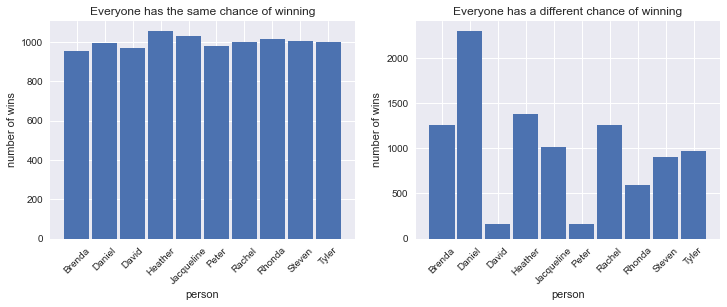

Person        Probability of winning
----------  ------------------------
Brenda                     0.1271
Daniel                     0.236299
David                      0.0180149
Heather                    0.132425
Jacqueline                 0.101157
Peter                      0.0154529
Rachel                     0.127028
Rhonda                     0.0587386
Steven                     0.090962
Tyler                      0.0928225


In [19]:
# Generate a list of ten people
fake_name = Faker()
people = [fake_name.unique.first_name() for _ in range(10)]

# Select one random winner with discrete uniform probability 10000 times
winners_uniform = rng.choice(people, size=10000)
# Generate 10 random probabilities summing to 1
# the Dirichlet distribution is a ditribution in which all of the sampled 
# values sum to 1, making it suitable for generating random probabilities
probabilities = rng.dirichlet(np.ones(10),size=1)[0]
# Select one random winner with probabilities generated above 10000 times
winners_skewed  = rng.choice(people, size=10000, p=probabilities)

# Plot histograms of the number of wins each person gets in both cases
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
for ax, data in zip((ax1, ax2), (winners_uniform, winners_skewed)):
    ax.hist(sorted(data), bins=range(11), align="left", rwidth=0.9)
    ax.set_xlabel('person')
    ax.set_ylabel('number of wins')
    ax.tick_params('x', labelrotation=45)
ax1.set_title("Everyone has the same chance of winning")
ax2.set_title("Everyone has a different chance of winning")
plt.show()

# Table showing each person's probability of winning
# in case where everyone has a different chance
print(tabulate(sorted(zip(people, probabilities)), 
               headers=["Person", "Probability of winning"]))

### `numpy.random.Generator.bytes`
Signature: `bytes(length)`

The `bytes` method returns a string of random bytes of the length passed.

In [20]:
x = rng.bytes(10)
print(x)

b'Y8\x9cU\xbdO(\xbe\xe4\r'


\xe2h\x18\x08\x04\xab\xeco

## Random permutations of sequences with `numpy.random`

Three methods are provided for the random reordering of sequences: `shuffle`, `permutation`, and `permuted`.

### `numpy.random.Generator.shuffle`
Signature: `shuffle(x, axis=0)`

The `shuffle()` method shuffles an array-like in-place. If passed an *n-d* array, the `axis` parameter, which defaults to 0, determines which axis gets shuffled. For instance, in the case of a *2-d* array, `axis=0` causes the order of the rows to change without reordering the values within the rows, while `axis=1` reorders the columns without affecting element order within the columns.

In [21]:
# array containing 1..16
a = np.arange(1,17)
print(f"Unshuffled array:\n{a}")
# shuffle in-place
rng.shuffle(a)
print(f"Same array shuffled:\n{a}")

# 4x4 array conatining 1..16
b = a.copy().reshape(4,4)
print(f"\nUnshuffled array:\n{b}")
rng.shuffle(b, axis=1)
print(f"Same array with column positions shuffled (axis=1):\n{b}")

Unshuffled array:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Same array shuffled:
[ 6  3  9  1 14  5  4 10 11  8  7 15  2 12 13 16]

Unshuffled array:
[[ 6  3  9  1]
 [14  5  4 10]
 [11  8  7 15]
 [ 2 12 13 16]]
Same array with column positions shuffled (axis=1):
[[ 6  1  9  3]
 [14 10  4  5]
 [11 15  7  8]
 [ 2 16 13 12]]


### `numpy.random.Generator.permutation`
Signature: `permutation(x, axis=0)`

The `permutation` method behaves similarly to the `shuffle` method except that it shuffles a copy of the passed *array-like* along the specified axis and returns that copy, leaving the original unchanged. If passed an int, $n$, the `permutation()` method generates an evenly spaced range of interval $[0, n)$ using `numpy.arange()`, shuffles it, then returns it as a *1-d* numpy array.

In [22]:
# array containing 1..10
a = np.arange(1,11)
print(f"Unshuffled array:\n{a}")
# shuffle in-place
b = rng.permutation(a)
print(f"Same array shuffled:\n{b}")
print(f"The original array is unchanged:\n{a}")

# 3x3 array containg 1..9
c = np.arange(1, 10).reshape(3,3)
print(f"\nUnshuffled 2d array:\n{c}")
# To shuffle all values independent of axis
d = rng.permutation(c.flatten()).reshape(3,3)
print(f"Shuffled on both axes:\n{d}")

Unshuffled array:
[ 1  2  3  4  5  6  7  8  9 10]
Same array shuffled:
[ 4  5  7  2  6  3  9  8  1 10]
The original array is unchanged:
[ 1  2  3  4  5  6  7  8  9 10]

Unshuffled 2d array:
[[1 2 3]
 [4 5 6]
 [7 8 9]]
Shuffled on both axes:
[[2 8 6]
 [7 1 9]
 [5 3 4]]


### `numpy.random.Generator.permuted`
Signature:`permuted(x, axis=None, out=None)`

This method differs from `shuffle` and `permutation` in that, rather than shuffling the order of slices along the specified axis, the values within each slice along that axis are shuffled. Like `permutation`, a copy is returned leaving the original unchanged. Like the flatten-reshape trick shown in the `permutation` example above, the n-d array will be flattened, shuffled, and reshaped if `axis=None`, which is its default value.

In [23]:
# 3x3 array containg 1..9
a = np.arange(1, 10).reshape(3,3)
# Shuffle all the values
b = rng.permuted(a)
print(f"Unshuffled array:\n{a}")
print(f"Same array shuffled without regard for axes:\n{b}")

# 4x4 array containing 1..16
c = np.arange(1, 10).reshape(3,3)
print(f"\nUnshuffled array:\n{c}")
rng.permuted(c, axis=1)
print(f"Same array with column values shuffled (axis=1):\n{b}")

Unshuffled array:
[[1 2 3]
 [4 5 6]
 [7 8 9]]
Same array shuffled without regard for axes:
[[6 5 9]
 [3 4 2]
 [7 1 8]]

Unshuffled array:
[[1 2 3]
 [4 5 6]
 [7 8 9]]
Same array with column values shuffled (axis=1):
[[6 5 9]
 [3 4 2]
 [7 1 8]]


## Some distribution functions

### 1. The normal distribution
#### `numpy.random.Generator.normal()`
Signature:`normal(loc=0.0, scale=1.0, size=None)`

The normal distribution is a symmetric probability distribution that is centred on the mean. It is extremely useful in statistics because many phenomena exhibit this distribution and it is often assumed for phenomena where the true population distribution is not known. This is often a safe guess because it has been shown that the sum of the effects phenomena with varying probability distributions will often look like a normal distribution. This is known as the *central limit theorem*. An intuitive description of the normal distribution would be that values close to the mean are more common than values far from the mean, and the further a value is from the mean, the less likely it is to occur. Mathematically, the probability density function of the normal distribution is given as: 

$$f(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2} \\
\text{where $\sigma$ is the standard deviation and $\mu$ is the mean.}$$

The *standard normal distribution* is a normal distribution with $\sigma=1$ and $\mu=0$. This is the default sampling distribution of `Generator.normal`. $\mu$ is declared using the `loc` parameter, and $\sigma$ with the scale parameter, as demonstrated below. Both parameters accept floats. The `size` parameter defines both the number of samples and the shape of the output array in a similar fashion to the `numpy.random.Generator` methods already discussed.

Below is a demonstration of the use of the `loc` and `scale` parameters to adjust the mean and standard deviation of the sampled distribution. The effect of changing these parameters is demonstrated by the histograms.

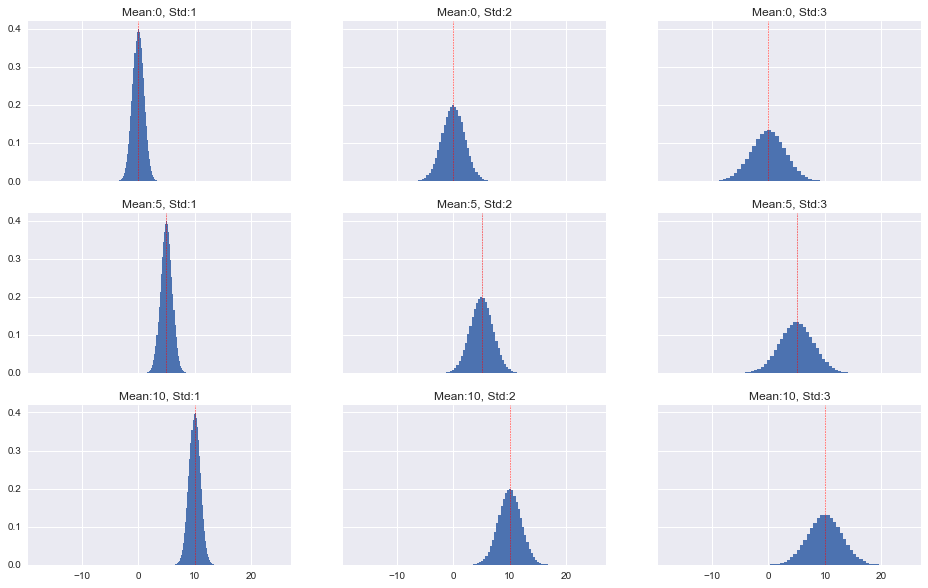

In [24]:
# Means and standard deviations for the distributions
means = [0, 5, 10]
stds = [1, 2, 3]

# 3x3 grid of histograms, all with the same x- and y-axes
fig, ax = plt.subplots(3, 3, sharex='all', sharey='all', figsize=(16,10))

# For each mean, std dev combination...
for i, mean in enumerate(means):
    for j, std in enumerate(stds):
        # Generate an array of random numbers drawn from 
        # normal distribution with that mean and std dev
        _, bins, _ =  ax[i, j].hist(rng.normal(loc=mean, scale=std, size=1000000), bins=50, density=True)
        ax[i, j].axvline(mean, color='r', linewidth=0.5, linestyle='dashed')
        ax[i, j].set_title(f"Mean:{mean}, Std:{std}")
        #y = ((1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * (1 / std * (bins - mean))**2))
        #ax[i, j].plot(bins, y, '-', color='r', alpha=0.5)


1. Tests for normality
2. QQ plots --- show with various sample sizes --- more samples = more normal
3. Demonstrate case of simulating normal pop for which sample is available to improve predictions

<AxesSubplot:ylabel='Probability'>

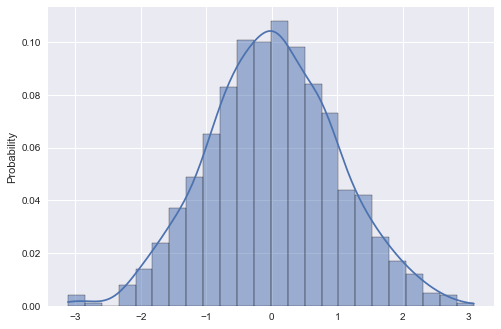

In [25]:

n = rng.normal(3,2.5,10)
s = rng.standard_normal(1000)
# h0 is that data is normally distributed
st = ss.shapiro(n)
st
sns.histplot(s, cumulative=False, kde=True, stat='probability')

In [26]:
#p-value > 0.05 ==> h0 not rejected, data comes from normal distribution
#p-value = 0.37 ===> 37% chance of seeing test statistic if h0 is true therfore h0 cannot be rejected and data comes from normal dist

In [27]:
ss.ttest_ind(n, s)

Ttest_indResult(statistic=7.565346602804169, pvalue=8.698590402375593e-14)

In [28]:
#h0 ==> both samples come from populaitons with same mean
# p is very small meaning there is a very small chance that h0 is true therefore h0 is rejected
# ===> n and s come from populations with different means
# x% of data looking like this coming from pops with same mean

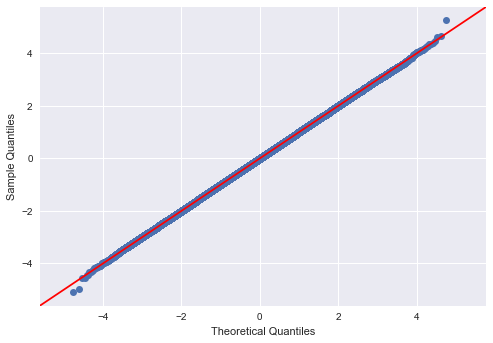

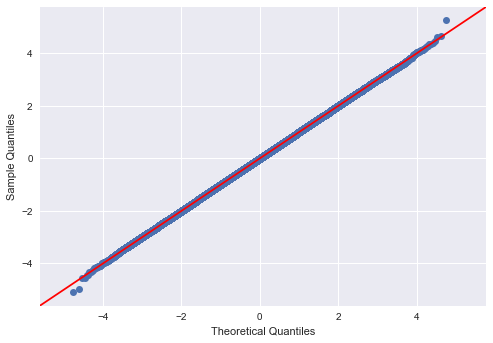

In [29]:
from statsmodels.graphics.gofplots import qqplot
small = rng.normal(0, 1, 1000000)

qqplot(small, line='45')

In [30]:
uniform = rng.random(1000000)
various = rng.permutation(uniform)[:10000]


(array([1059., 1013.,  970.,  993.,  973., 1004., 1043.,  959., 1015.,
         971.]),
 array([2.98883438e-05, 1.00021517e-01, 2.00013146e-01, 3.00004775e-01,
        3.99996404e-01, 4.99988033e-01, 5.99979662e-01, 6.99971290e-01,
        7.99962919e-01, 8.99954548e-01, 9.99946177e-01]),
 <BarContainer object of 10 artists>)

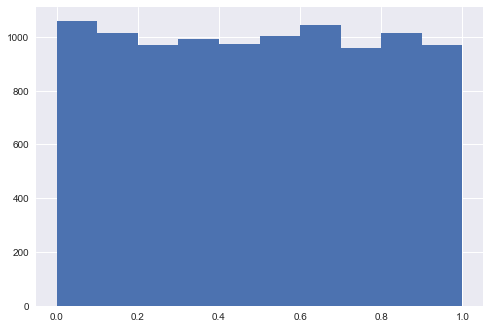

In [31]:
plt.hist(various)

### 2. The binomial distribution
#### `numpy.random.Generator.binomial()`
Signature:`binomial(n, p, size=None))`

The binomial distribution is the probability distribution of the number of successes in a series of Bernoulli trials, that is, trials in which there are two possible outcomes. The canonical example of a Bernoulli trial is the toss of a coin and the probability distribution of a series of tosses is the binomial distribution. The probability function of the distribution is 
$$P(N)={n \choose N}p^N(1-p)^{n-N}\\
\text{where N is the number of successes, n the number of trials, and p the probability of a success}$$

`Generator.binomial()` takes 3 parameters; `n`, which represents the number of trials in a series; `p`, the probability of success in each trial; and `size`, the size and shape of the output array, representing the number of times the experiment, consisting of $n$ trials, is repeated.

Using the above probability density function, if we know the probability of a successful trial we can calculate the probability of any number of successes from any number of trials. This is useful because many phenomena for which data exists, or can be collected, can be cast as Bernoulli processes. The example below takes the simple case of a fair coin.

The probability of tossing a fair coin and getting a head is 0.5. This knowledge can be used to calculate the probability of getting, for instance, exactly fifty heads in one hundred tosses using the probability density function defined above.

In [32]:
# num trials, num successes, probability of success
n, N, p = 100, 50, 0.5
# calculate probability of 50 successes
def binom_prob(n, N, p):
    return comb(n, N)*(p**N)*((1-p)**(n-N))

p_50 = binom_prob(n, N, p)
print(p_50)

0.07958923738717877


The result is 0.796. That is, the probability, according to the function, of getting exactly fifty heads in one hundred tosses of a fair coin is 0.796. To confirm this `Generator.binomial()` can be used to simulate those one hundred coin tosses many times. Below, a series of one hundred tosses is simulated one million times and the result recorded each time. 

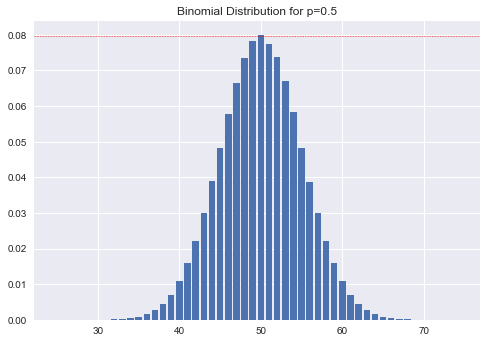

Probability of 50 heads in 100 tosses: 0.079924


In [33]:
def trial(n, p, size, line_loc=None):
    
    # Simulate the experiments 
    binom = rng.binomial(n, p, size=size)
    # count the successes
    successes, trials = np.unique(binom, return_counts=True)

    # plot the results
    plt.figure()
    plt.bar(successes, trials/size, linewidth=0)
    if line_loc:
        plt.axhline(line_loc, linewidth=0.5, color='r', linestyle='dashed')
    plt.gca().set_title(f"Binomial Distribution for p={p}")
    plt.show()

    return binom

n, p, size = 100, 0.5, 1000000
# Number of trials, probability of success, number of experiments
binom = trial(n=n, p=p, size=size, line_loc=p_50)

# Calculate the probability of 
# exactly 50 heads in 100 tosses
print(f"Probability of 50 heads in 100 tosses: {sum(binom == 50)/size}")

The probability shown by experiment is the same as that calculated by the probability density function.

Below is the same experiment simulated with a weighted coin that favours heads, giving a probability of 0.6 that a toss will come up heads. In that case the probability of getting 50 heads in one hundred tosses is 0.01.

0.01033751125384763


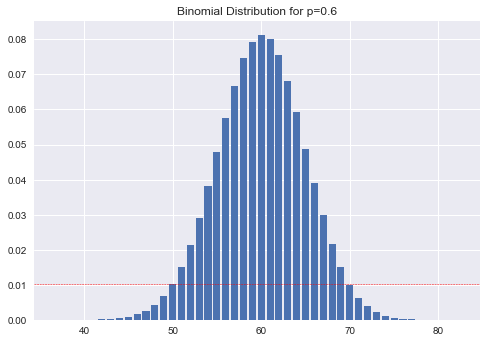

Probability of 50 heads in 100 tosses: 0.010279


In [34]:
p_50 = binom_prob(100, 50, 0.6)
print(p_50)
binom = trial(n=100, p=0.60, size=1000000, line_loc=p_50) 
print(f"Probability of 50 heads in 100 tosses: {sum(binom == 50)/size}")

### 3. The Poisson distribution
#### `numpy.random.Generator.poisson()`
Signature:`poisson(lam=1.0, size=None)`

The Poisson distribution models the number of times an event will occur in a given interval, given the average number of times that event occurs in that interval. The probability density function is
$$f(k;\lambda)=\frac{\lambda^{k}e^{-\lambda}}{k!} \\
\text{where k is the number of events and $\lambda$ is the average number of events in the interval}$$

This can be interpreted as the probability that a given discrete, independent event will occur $k$ times in a particular interval given that the mean or expected number of times it will occur in that interval, $\lambda$, is known. 

`Generator.poisson()` takes just two parameters; `lam`, which is lambda, the average number of times the event of interest occurs in the given interval; and size, which specifies the size and shape of the output array.

For a phenomenon to be modeled by the Poisson distribution it must consist of discrete, independent events which occur zero or more times in a  given interval. Common examples are the number of calls to a call centre in a given hour, the number of births in a hospital in a given hour, or the number of meteorites entering the earth's atmosphere in a given year.

`Generator.poisson` is demonstrated below using as an example an imaginary hospital which delivers, on average, 2 babies per hour.

In [87]:
#
births_per_hour = rng.poisson(2,100000)

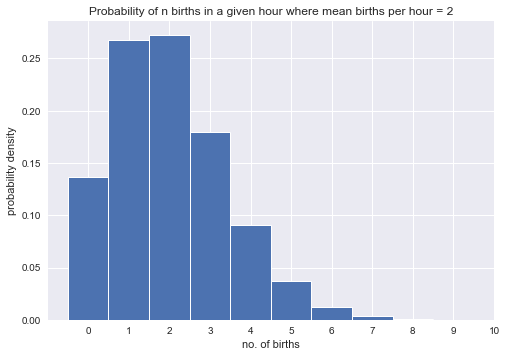

In [88]:
vals, bins, hist = plt.hist(births_per_hour, bins=range(len(np.unique(births_per_hour))), 
                      density=True, linewidth='1', edgecolor='white', 
                      align='left')
ax = plt.gca()
ax.set_title("Probability of n births in a given hour where mean births per hour = 2")
ax.set_xlabel("no. of births")
ax.set_ylabel("probability density")
ax.set_xticks(bins)
plt.show()

In [89]:
print(tabulate(zip(vals,bins), headers=("Probability", "No. of births")))

  Probability    No. of births
-------------  ---------------
  0.136201                   0
  0.267493                   1
  0.272243                   2
  0.180012                   3
  0.0903409                  4
  0.0366904                  5
  0.0119901                  6
  0.00385004                 7
  0.000900009                8
  0.000280003                9


### 4. The Exponential Distribution
#### `random.Generator.exponential`
Signature: `exponential(scale=1.0, size=None)`


The exponential distribution is the distribution of the probability of the time between Poisson-distributed events. It is useful for modeling phenomena where there is a large number of short intervals and a small number of larger ones, like radioactive decay time, component failures, and queues [19]. The exponential probability density function is
$$ f(x; \frac{1}{\beta})=\begin{cases}\frac{1}{\beta}exp(-\frac{x}{\beta}), x<0\\
0, x\le 0 \\
\end{cases} \\
\text{where $\beta$ is the scale parameter an is inverse of $\lambda$ in Poisson distribution above [20]}
$$

`Generator.exponential` takes two parameters, `scale`, which is the $\beta$ parameter, and `size` which, as usual, specifies the shape and length of the output array. In the description of the [Poisson distribution](#The-Poisson-distribution), above, the number of births per hour at an imaginary hospital was modeled. Because the exponential distribution can be used to model the time between Poisson events, `generator.exponential()` can be demonstrated by modeling the time between births at that same hospital. The average number of births per hour at that hospital was 2. This is the $\lambda$ parameter. The exponential distribution's $\beta$ parameter is the inverse of the Poisson's $\lambda$ when it represents the intervals between that Poisson distribution's events. Therefore, to model the number of hours between births at the hospital, a $\beta$ value of $\frac{1}{2}$, or 0.5 should be used. However, it is probably more instructive to model the time between births in minutes so we should divide $\lambda$ by 60 before inverting it. Now, $\beta$ is $\frac{1}{\frac{1}{60}}=30$:

In [76]:
# Generate exponential distribution representing 
# number of minutes between births
times_between_births = rng.exponential(30, 100000)

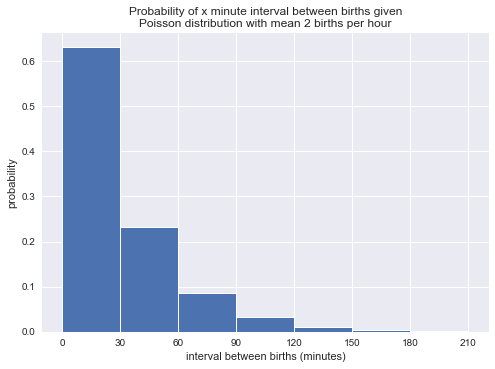

In [102]:
# calculate weights to convert density values on y-axis of histogram 
# to probabilities (see https://stackoverflow.com/a/16399202)
weights = np.ones_like(times_between_births) / len(times_between_births)
# Plot histogram with 30 minute bins
vals, bins, hist = plt.hist(times_between_births, 
                            bins=(range(0, 211, 30)),
                            weights=weights, 
                            linewidth='1', 
                            edgecolor='white')
# Title, labels, etc
ax = plt.gca()
ax.set_xticks(bins)
ax.set_xlabel('interval between births (minutes)')
ax.set_ylabel('probability')
plt.title("""Probability of x minute interval between births given
Poisson distribution with mean 2 births per hour""");

In [110]:
# Print table of probabilities of time intervals
bin_ranges = [f"{bins[i]} - {bins[i+1]}" for i in range(len(bins) - 1)]
print(tabulate(zip(vals,bin_ranges), 
               headers=("\nProbability", "Time between births\n(minutes)")))

               Time between births
  Probability  (minutes)
-------------  ---------------------
      0.63129  0 - 30
      0.23221  30 - 60
      0.08634  60 - 90
      0.03194  90 - 120
      0.01159  120 - 150
      0.00414  150 - 180
      0.00162  180 - 210


***
### 5. The Hypergeometric Distribution
#### `numpy.random.Generator.hypergeometric`
Signature:`hypergeometric(ngood, nbad, nsample, size=None)`

The hypergeometric distribution is similar to the [binomial distribution](#2.-The-binomial-distribution) in that it models the probability of a particular number of successes from a series of trials, but in the case of the hypergeometric the trials are conducted without replacement, meaning that the probability of a success decreases with each trial [17] or, to put it another way, the binomial sample space is infinite and the hypergrometric is finite. In fact, as the hypergeometric sample space increases, the distribution approaches the binomial [18]. A common example of the distribution is a jar containing $N$ marbles, $K$ of which are black and the rest of which are white. If $n$ marbles are drawn at random from the jar, the probability that $k$ of them will be black (a success) is given by [17]:

$$P(k)=\frac{{K \choose k}{N-K \choose n-k}}{{N \choose n}}$$

`Generator.hypergeometric()` takes four parameters. `ngood` and `nbad` equate to the numbers of black ($K$) and white ($N-K$) marbles respectively in the example above. $N$, the sample space - equating to the total number of marbles in the example above, is extrapolated as `ngood` + `nbad`. `nsample`, the sample size,  is equivalent to $n$ in the example above. Finally, `size`, as usual, sets the size and shape of the output array and therefore of the number of times to repeat the experiment [18].

Below, `Generator.hypergeometric()` is used to simulate one million National Lottery draws, or one million entries to one draw. The lottery draw is modeled as a collection of numbers, six of which are good - the six you have picked - and forty-one of which are bad. Six numbers are drawn, without replacement, each of one million times. The results are plotted in the histogram below.

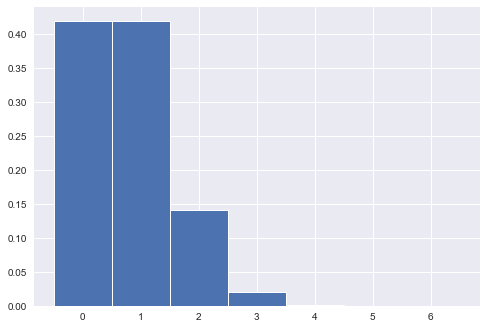

In [128]:

hg = rng.hypergeometric(6, 41, 6, 1000000)
vals, bins, hist = plt.hist(hg, density=True, bins=range(8),
                            linewidth='1', edgecolor='white', 
                            align='left')

plt.show()

In [129]:
print(tabulate(zip(vals,bins), headers=("\nProbability", "Number of matches")))

                 Number of matches
  Probability
-------------  -------------------
     0.418893                    0
     0.418304                    1
     0.141664                    2
     0.019948                    3
     0.001161                    4
     2.9e-05                     5
     1e-06                       6


***
## References

## RNG General
[1] https://www.pcg-random.org/rng-basics.html

### PCG
[2] Lemire, D., 2017, On Melissa O’Neill’s PCG random number generator, https://lemire.me/blog/2017/08/15/on-melissa-oneills-pcg-random-number-generator/

[3] O' Neill, M., 2014, PCG, A Family of Better Random Number Generators, https://www.pcg-random.org/

[4] O' Neill, M., 2014, PCG: A Family of Simple Fast Space-Efficient Statistically Good Algorithms for Random Number Generation, https://www.pcg-random.org/pdf/hmc-cs-2014-0905.

### RNG Seeding
[5] Woodcock, H., 2021, Stop using numpy.random.seed(), https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f

### Numpy Docs
[7] https://numpy.org/doc/stable/reference/random/index.html

[8] https://numpy.org/doc/stable/reference/random/bit_generators/index.html

[9] https://numpy.org/doc/stable/reference/random/bit_generators/generated/numpy.random.BitGenerator.html

[10] Generating random samples from user-defined
distributions
The Stata Journal (2011)
11, Number 2, pp. 299–304
Katar ́ına Luk ́acsy

[11] Bonilla, L.L., Alvaro, M. & Carretero, M. Chaos-based true random number generators. J.Math.Industry 7, 1 (2016). https://doi.org/10.1186/s13362-016-0026-4

[12] Harvard: Haahr, M. (2021). RANDOM.ORG: True Random Number Service. [ONLINE] Available at: https://www.random.org [Accessed 9 November 2021].

[13] Meiser, L.C., Koch, J., Antkowiak, P.L. et al. DNA synthesis for true random number generation. Nat Commun 11, 5869 (2020). https://doi.org/10.1038/s41467-020-19757-y

[14] Neustadter, D. (2019). True Random Number Generators for Heightened Security in Any SoC. [ONLINE] Available at https://www.synopsys.com/designware-ip/technical-bulletin/true-random-number-generator-security-2019q3.html [Accessed 9 November 2021].

[15] Barker, E., Kelsey, J. (2012). Recommendation for Key Management. NIST Special Publication 800-57. NIST. [Accessed 9 November 2021]. Page 4.

[16] https://en.wikipedia.org/wiki/Binomial_coefficient

[17] https://en.wikipedia.org/wiki/Hypergeometric_distribution

[18] https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.hypergeometric.html

[19] Forbes, C., Evans, M., Hastings, N., Peacock, B., 2011, Statistical Distributions, 4th Ed., Wiley: New Jersey. P. 88

[20] https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.exponential.html